In [4]:
#Below is the code to generate the BCS Trotter circuit for 3 qubits

from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, transpile, assemble, QuantumRegister, ClassicalRegister
from sympy import symbols, solve
from scipy import linalg
import math , cmath
import numpy as np
from functions_BCS_Trotter import *

#Parameters of the BCS model (3 qubits system)
dt=0.2 #Trotter time step
energies=[-1,0,1] #on site energy from qubit Q0 to Q2
g=0.5 #coupling constant
initial_step=1 # initial Trotter step 
final_step=15 #final Trotter step
#measurement='ZZZ' 
measurement='XYZ'

#In the data folder, the resulting circuit are transpiled to fit the layout of the 'ibm_lagos' machine 
#but can be easily modified by changing the backend variable in this notebook
#If you do not have access to 'ibm_lagos' but wish to transpile the circuit with this machine 
#you can choose instead the transpile option 'coupling'

#EXAMPLE WITH IBM_LAGOS
# Load IBM Q account and get the backend device (for transpiling the circuit)
provider = IBMQ.load_account()
#provider = IBMQ.get_provider('NAME OF YOUR PROVIDER TO GET ACCESS TO THE CORRESPONDING BACKEND')
provider=IBMQ.get_provider('ibm-q-fraunhofer')
backend = provider.get_backend('ibm_lagos')
#if you have no access to the device 'ibm_lagos' you can transpile it using its coupling map
coupling_map=[[0, 1],[1, 0],[1, 2],[1, 3],[2, 1],[3, 1],[3, 5],[4, 5],[5, 3],[5, 4],[5, 6],[6, 5]]

transpile_option='backend'#whether you want to transpile knowing the device or only the its coupling map
#transpile_option='coupling'


#initial layout of the qubits used 
ini_lay=[0,1,2] #choose qubits in the backend with a linear coupling map
                #(here for backend:'ibm_lagos', the coupling map for the initial layout is 0-1-2)
    

ibmqfactory.load_account:WARNING:2023-02-24 17:20:31,773: Credentials are already in use. The existing account in the session will be replaced.


For g=0.5, dt=0.2, ini_lay=[0,1,2], backend='ibm_lagos',energies=[-1,0,1] from initial_step=1 to final_step=15
the corresponding BCS Trotter circuits are available in QASM format for both measurements (XYZ/ZZZ) in the folder data, the corresponding folder measurement and at their corresponding time step folder under the name 'trotter_g=0.5=dt=0.2_backend=ibm_lagos.qasm'

Same for backend='ibmq_ehningen' with ini_lay=[18,21,23] (only XYZ measurement)

In [5]:
#Trotter Circuit

L=3 #system size
qc_list=list([] for _ in range(final_step-initial_step+1))#circuits for the different Trotter steps

#Creation of the Trotter circuit
data=QuantumRegister(L,'data')
qc=QuantumCircuit(data)

#initialisation of the mean field state
ini_state=initial_angle(energies,g)
for i in range(L):
    qc.ry(ini_state[i],i)
if transpile_option=='backend':
    qct=transpile(qc,backend=backend,optimization_level =3,initial_layout=ini_lay,
              basis_gates=['cx','x','sx','rz','id'],approximation_degree=1)#optimization of the initial state
elif transpile_option=='coupling':
    qct=transpile(qc,coupling_map=coupling_map,optimization_level =3,initial_layout=ini_lay,
              basis_gates=['cx','x','sx','rz','id'],approximation_degree=1)
qct.barrier()

#Trotter steps
lay=ini_lay.copy()
for t in range(initial_step,final_step+1):
    for k in range(L):
        qct.rz((-2*energies[k]+g)*dt,lay[k]) #gates for the on-site energies
    for j in range(L-1):
        for l in range(j+1,L):
            if [lay[l],lay[j]] in backend.configuration().coupling_map:
                qct.append(interaction(-dt*g),[lay[l],lay[j]]) #coupling between adjacent qubits
                qct.barrier()
            else:
                not_neigh=[l,j]#not neighbouring qubits (here only one couple for system size 3)
    qct.cx(lay[1],lay[2])#SWAP between physical qubits 1 and 2
    qct.cx(lay[2],lay[1])#here the SWAP is introduced manually to control on which qubit it acts
    qct.cx(lay[1],lay[2]) #You have to adapt this code if the coupling map is different from 0-1-2 
    qb_1=lay[1]
    qb_2=lay[2]
    lay1=lay.index(qb_1)
    lay2=lay.index(qb_2)
    lay[lay1]=qb_2
    lay[lay2]=qb_1 #exchanging qubits swapped in the layout
    qct.append(interaction(-dt*g),[lay[not_neigh[0]],lay[not_neigh[1]]])#coupling between the two remaining qubits
    qct.barrier()
    if transpile_option=='backend':
        qc2=transpile(qct,backend=backend,optimization_level =3,
                  initial_layout=list(i for i in range(backend.configuration().num_qubits)),
                  basis_gates=['cx','x','sx','rz','id'],approximation_degree=1) #Final optimization
    elif transpile_option=='coupling':
        qc2=transpile(qct,coupling_map=coupling_map,optimization_level =3,
                  initial_layout=list(i for i in range(backend.configuration().num_qubits)),
                  basis_gates=['cx','x','sx','rz','id'],approximation_degree=1) #Final optimization
    
    qc_list[t-initial_step]=qc2


In [6]:
#Add final measurement

qc_meas_list=list([] for _ in range(final_step-initial_step+1))#circuits with measurement for the different Trotter steps


for k in range(len(qc_list)):
    qc=qc_list[k].copy()
    cr=ClassicalRegister(3)
    qc.add_register(cr)
    
    if measurement=='ZZZ':
        qc.measure(ini_lay[0],0)#Measurement protocol is always in the same order  first measure physical qubit 0, then 1, then 2
        qc.measure(ini_lay[1],1) #but which logical qubit has been measured depends on the number of SWAP
        qc.measure(ini_lay[2],2)# this will be handle in post-analysis script
        
    if measurement=='XYZ':
        t=k+initial_step
        if t//2*2!=t: #keep track of the number of SWAP in order to perform the measurement in the corresponding direction
            lay_meas=[ini_lay[0],ini_lay[2],ini_lay[1]]#odd number of SWAP for odd time Trotter step 
        else:
            lay_meas=[ini_lay[0],ini_lay[1],ini_lay[2]]##even number of SWAP for even time Trotter step
        qc.h(lay_meas[0])# Measurement in X direction
        qc.u(np.pi/2,0,np.pi/2,lay_meas[1])# Measurement in Y direction
        qc.barrier()
        qc.measure(ini_lay[0],0)
        qc.measure(ini_lay[1],1) 
        qc.measure(ini_lay[2],2)
    qc_meas_list[k]=transpile(qc,optimization_level =0,basis_gates=['cx','x','sx','rz','id'],approximation_degree=1)
        

        

In [ ]:
for k in range(len(qc_meas_list)):
    display(qc_meas_list[k].draw('mpl'))

In [8]:
#Simulation of the Trotter circuit on a perfect QC

nb_shots=32000 #number of shots
sim = Aer.get_backend('aer_simulator')
counts=list({} for _ in range(len(qc_meas_list)))
for i in range(len(qc_meas_list)):
    qobj = assemble(qc_meas_list[i])
    counts[i]= sim.run(qobj,shots=nb_shots).result().get_counts()

####
#The dictionnary counts is saved in the corresponding folder measurement 
#under the file name 'results_simulation_Trotter_perfect.json'
####

In [9]:
#Computing the 7 different observables from the perfect simulation

#convert the dictionnary counts in an array
data_counts=list(np.zeros(8) for _ in range(len(qc_meas_list)))
for i in range(len(qc_meas_list)):
    for bit_0 in range(2):
        for bit_1 in range(2):
            for bit_2 in range(2):
                ind=bit_0*4+bit_1*2+bit_2
                bit_string=str(bit_0)+str(bit_1)+str(bit_2)
                if bit_string in counts[i]:
                    data_counts[i][ind]=counts[i][bit_string]/nb_shots

#list of the different observables one can have access, numbers correspond to the measured qubits                  
meas_list=[[0],[1],[2],[0,1],[0,2],[1,2],[0,1,2]]

sim_obs=list(list( 0. for _ in range(len(qc_meas_list))) for _ in range(7))

for t in range(initial_step,final_step+1):
    if t//2*2!=t:
        lay=[0,2,1]
    else:
        lay=[0,1,2]#take into account the final layout at different time due to SWAP gate
    for obs in range(len(meas_list)):
        m=list(lay[meas] for meas in meas_list[obs])
        sim_obs[obs][t-initial_step]=sum((-1)**(sum(k//2**m[i] for i in range(len(m))))*data_counts[t-initial_step][k]  for k in range(8))



In [10]:
#Exact diagonalisation of BCS from t=0 to final Trotter step

#list of possible observable for the ZZZ measurement (Z0,Z1,Z2,Z0Z1,Z0Z2,Z1Z2,Z0Z1Z2) 
#written in the Pauli basis (X0Z0X1Z1X2Z2)
if measurement=='ZZZ':
    list_obs=[[0,1,0,0,0,0],[0,0,0,1,0,0],[0,0,0,0,0,1],[0,1,0,1,0,0],[0,1,0,0,0,1],[0,0,0,1,0,1],[0,1,0,1,0,1]]

#same for the XYZ measurement
elif measurement=='XYZ':
    list_obs=[[1,0,0,0,0,0],[0,0,1,1j,0,0],[0,0,0,0,0,1],[1,0,1,1j,0,0],[1,0,0,0,0,1],[0,0,1,1j,0,1],[1,0,1,1j,0,1]]

list_obs_op=list(observable_operator(obs) for obs in list_obs)

#initialization of the M-F ground state
ini_angle=initial_angle(energies,g)
ini_state=np.array([np.cos(ini_angle[0]/2),np.sin(ini_angle[0]/2)])
for angle in ini_angle[1:]:
    ini_state=np.kron([np.cos(angle/2),np.sin(angle/2)],ini_state)

#array for the evolution of the 7 different observables
evolution_obs = np.zeros([7,final_step+1,2])
for i in range(7):
    evolution_obs[i][0]= [0,np.matmul(ini_state.conj().T,np.matmul(list_obs_op[i],ini_state))]


L=len(energies)
H_BCS=BCS_classic(energies,g) #construct the BCS hamilotnian
vals,vecs=linalg.eigh(H_BCS) #find the eigenvalues and eigenvectors
ini_ev=np.matmul(linalg.inv(vecs),ini_state) #write the initial state in the eigenbasis
for j in range(1,final_step+1):
    state=np.zeros_like(ini_ev)
    for i in range(2**L):
        state[i]=np.exp(-1j*vals[i]*j*dt)*ini_ev[i]#evolution of the state in the eigenbasis
    state=np.matmul(vecs,state) #transform the state back to the original basis
    for k in range(7):
        evolution_obs[k][j]=[j*dt,np.matmul(state.conj().T,np.matmul(list_obs_op[k],state))]
        

C:\Users\hugop\AppData\Local\Temp/ipykernel_9584/3331559690.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution_obs[i][0]= [0,np.matmul(ini_state.conj().T,np.matmul(list_obs_op[i],ini_state))]
C:\Users\hugop\AppData\Local\Temp/ipykernel_9584/3331559690.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution_obs[k][j]=[j*dt,np.matmul(state.conj().T,np.matmul(list_obs_op[k],state))]


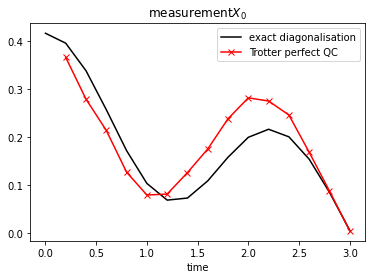

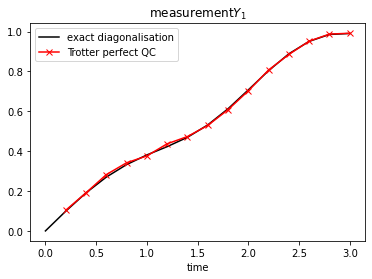

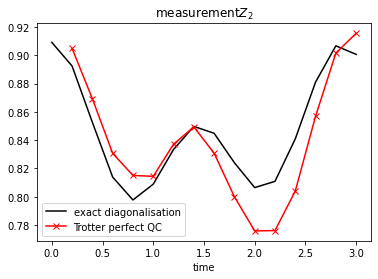

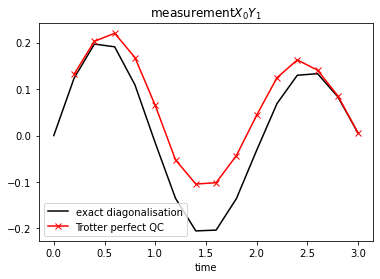

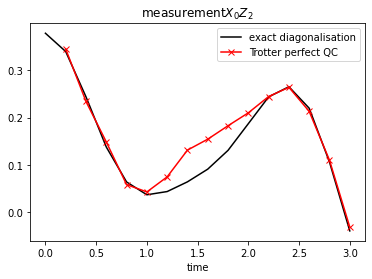

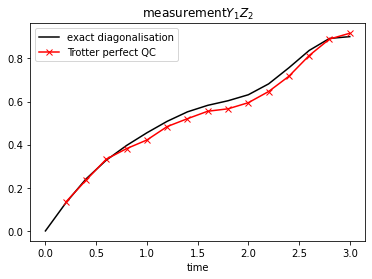

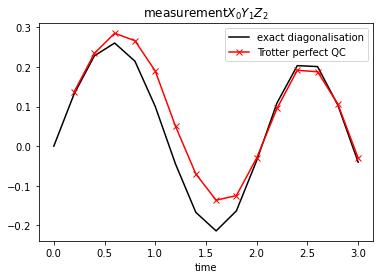

In [11]:
import matplotlib.pyplot as plt

t=list(i*dt for i in range(initial_step,final_step+1))

if measurement=='ZZZ':
    title=['$Z_0$', '$Z_1$','$Z_2$','$Z_0 Z_1$','$Z_0 Z_2$','$Z_1 Z_2$','$Z_0 Z_1 Z_2$']
    
if measurement=='XYZ':
    title=['$X_0$', '$Y_1$','$Z_2$','$X_0 Y_1$','$X_0 Z_2$','$Y_1 Z_2$','$X_0 Y_1 Z_2$']
for obs in range(7):
    plt.plot(evolution_obs[obs,::,0], evolution_obs[obs,::,1],'k',label='exact diagonalisation')    
    plt.plot(t,sim_obs[obs],'-x', color='red',label='Trotter perfect QC')
    plt.xlabel('time')
    plt.title('measurement'+title[obs])
    plt.legend()
    plt.show()